In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
df_train = pd.read_csv("crime-train.csv")
df_test = pd.read_csv("crime-test.csv")

In [4]:
print('Shape of df_train :', df_train.shape)
df_train.head()

Shape of df_train : (1595, 96)


,ViolentCrimesPerPop,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.67,-0.45,-1.85,-1.06,0.67,0.08,-0.85,-0.34,0.68,-0.24,...,-0.23,-0.02,-0.53,-1.08,-0.13,-0.66,-0.41,-0.56,1.26,-0.39
1,0.43,-0.45,-0.27,-0.22,-0.17,-0.34,-0.58,-0.50,-1.57,-0.29,...,-0.23,-0.33,-0.58,0.03,0.22,-0.46,-0.50,-0.11,-0.62,-0.39
2,0.12,-0.14,1.87,0.55,0.04,0.02,-1.19,-0.03,0.68,1.05,...,-0.23,-0.11,-1.51,1.07,0.07,-0.01,-0.41,0.77,0.52,-0.39
3,0.03,-0.38,0.53,-0.28,-0.79,-0.64,-0.35,-0.34,0.46,0.66,...,-0.23,-0.46,0.54,0.58,-0.08,-0.61,-0.23,-0.70,-0.62,-0.39
4,0.14,-0.30,-1.12,-0.74,-0.10,-0.40,-0.30,-0.19,0.68,0.76,...,-0.23,2.10,-0.92,-0.25,0.52,-0.06,-0.50,1.71,-0.27,-0.39


In [5]:
print('Shape of df_test :', df_test.shape)
df_test.head()

Shape of df_test : (399, 96)


,ViolentCrimesPerPop,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.08,-0.14,0.35,-0.41,-0.10,-0.46,-1.41,-0.11,0.48,1.43,...,-0.23,-0.24,-1.17,-0.19,-0.93,-0.61,0.13,-0.65,0.65,-0.39
1,0.22,0.02,-0.45,-0.22,-0.24,-0.40,-0.19,0.12,0.68,-0.29,...,-0.23,-0.80,0.49,-0.36,-0.08,-0.26,0.68,-0.70,-0.66,-0.39
2,0.06,-0.45,0.28,-0.16,0.18,-0.46,-1.25,-0.34,0.68,0.14,...,-0.23,-0.67,0.05,-0.03,-0.18,-0.71,-0.50,-0.26,-0.66,-0.39
3,0.16,0.02,-0.27,-0.67,-0.51,-0.58,-0.69,0.12,0.68,0.95,...,-0.23,0.54,-0.68,-0.74,-0.68,-0.41,0.13,-0.46,1.22,-0.39
4,0.15,-0.22,1.20,3.71,3.53,3.99,-1.19,-0.11,0.68,-1.25,...,-0.23,0.54,-0.63,-2.84,-3.12,-3.29,-0.50,1.07,0.78,-0.39


## I. Lasso method 
### Coordinate Descent Lasso regression with below conditions

> a. Consider intercept terms   
> b. Consider soft thresholding    
> c. Loss function = RSS   
> d. Initialize weight vectors to random Gaussian with mean of 0 and standard deviation of 1    
> e. Convergence condition: $||\hat w_t - \hat w_{t+1}||_\infty < 10^{-6}$, i.e., $max(abs(\hat w_t - \hat w_{t+1})) < 10^{-6}$, where $t$ is a number of iteration  
> f. Set $\lambda = 600$

- Plot training error (sum of squared error)

In [6]:
def insert_intercept(dataframe):
    
    dataframe.insert(1, 'intercept', 1)
    
    return dataframe


def split_data(dataframe):

    X = dataframe.iloc[:, 1:].to_numpy()
    y = dataframe.iloc[:, 0].to_numpy()

    return X, y


def CoordinateLasso(X, y, lambda_):
    
    np.random.seed(0)
    training_error_history = []
    
    w = np.random.normal(0, 1, X.shape[1])
    z = np.power(X, 2).sum(axis=0)
    
    while True:
        w_temp = w.copy()
        for j in range(X.shape[1]):
            w_temp[j] = 0
            p_j = np.sum(X[:, j]*(y-np.dot(X, w_temp)))
            if j == 0:
                w_temp[j] = p_j/z[j]
            else:
                if p_j < -lambda_/2:
                    w_temp[j] = (p_j+lambda_/2)/z[j]
                elif p_j > lambda_/2:
                    w_temp[j] = (p_j-lambda_/2)/z[j]
        training_error_history.append(np.power(y-np.dot(X, w_temp), 2).sum())
        
        if np.max(np.abs(w-w_temp)) < 10**(-6):
            break
            
        w = w_temp
            
    return w, training_error_history


def plot_error_over_iterations(error_history):
    
    fig = plt.figure(figsize =(30,7))
    fontsize, markersize = 30, 20
    
    plt.plot(error_history, marker='*', markersize=markersize)
    plt.title('Training error over iterations', fontsize=fontsize)
    plt.xlabel('Iterations', fontsize=fontsize)
    plt.ylabel('Squared errors', fontsize=fontsize)
    plt.show()
    
    return fig

In [7]:
df_train = insert_intercept(df_train)
df_test = insert_intercept(df_test)

In [8]:
print('Shape of df_train :', df_train.shape)
df_train.head()

Shape of df_train : (1595, 97)


,ViolentCrimesPerPop,intercept,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.67,1,-0.45,-1.85,-1.06,0.67,0.08,-0.85,-0.34,0.68,...,-0.23,-0.02,-0.53,-1.08,-0.13,-0.66,-0.41,-0.56,1.26,-0.39
1,0.43,1,-0.45,-0.27,-0.22,-0.17,-0.34,-0.58,-0.50,-1.57,...,-0.23,-0.33,-0.58,0.03,0.22,-0.46,-0.50,-0.11,-0.62,-0.39
2,0.12,1,-0.14,1.87,0.55,0.04,0.02,-1.19,-0.03,0.68,...,-0.23,-0.11,-1.51,1.07,0.07,-0.01,-0.41,0.77,0.52,-0.39
3,0.03,1,-0.38,0.53,-0.28,-0.79,-0.64,-0.35,-0.34,0.46,...,-0.23,-0.46,0.54,0.58,-0.08,-0.61,-0.23,-0.70,-0.62,-0.39
4,0.14,1,-0.30,-1.12,-0.74,-0.10,-0.40,-0.30,-0.19,0.68,...,-0.23,2.10,-0.92,-0.25,0.52,-0.06,-0.50,1.71,-0.27,-0.39


In [9]:
print('Shape of df_test :', df_test.shape)
df_test.head()

Shape of df_test : (399, 97)


,ViolentCrimesPerPop,intercept,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.08,1,-0.14,0.35,-0.41,-0.10,-0.46,-1.41,-0.11,0.48,...,-0.23,-0.24,-1.17,-0.19,-0.93,-0.61,0.13,-0.65,0.65,-0.39
1,0.22,1,0.02,-0.45,-0.22,-0.24,-0.40,-0.19,0.12,0.68,...,-0.23,-0.80,0.49,-0.36,-0.08,-0.26,0.68,-0.70,-0.66,-0.39
2,0.06,1,-0.45,0.28,-0.16,0.18,-0.46,-1.25,-0.34,0.68,...,-0.23,-0.67,0.05,-0.03,-0.18,-0.71,-0.50,-0.26,-0.66,-0.39
3,0.16,1,0.02,-0.27,-0.67,-0.51,-0.58,-0.69,0.12,0.68,...,-0.23,0.54,-0.68,-0.74,-0.68,-0.41,0.13,-0.46,1.22,-0.39
4,0.15,1,-0.22,1.20,3.71,3.53,3.99,-1.19,-0.11,0.68,...,-0.23,0.54,-0.63,-2.84,-3.12,-3.29,-0.50,1.07,0.78,-0.39


In [10]:
X_train, y_train = split_data(df_train)
X_test, y_test = split_data(df_test)

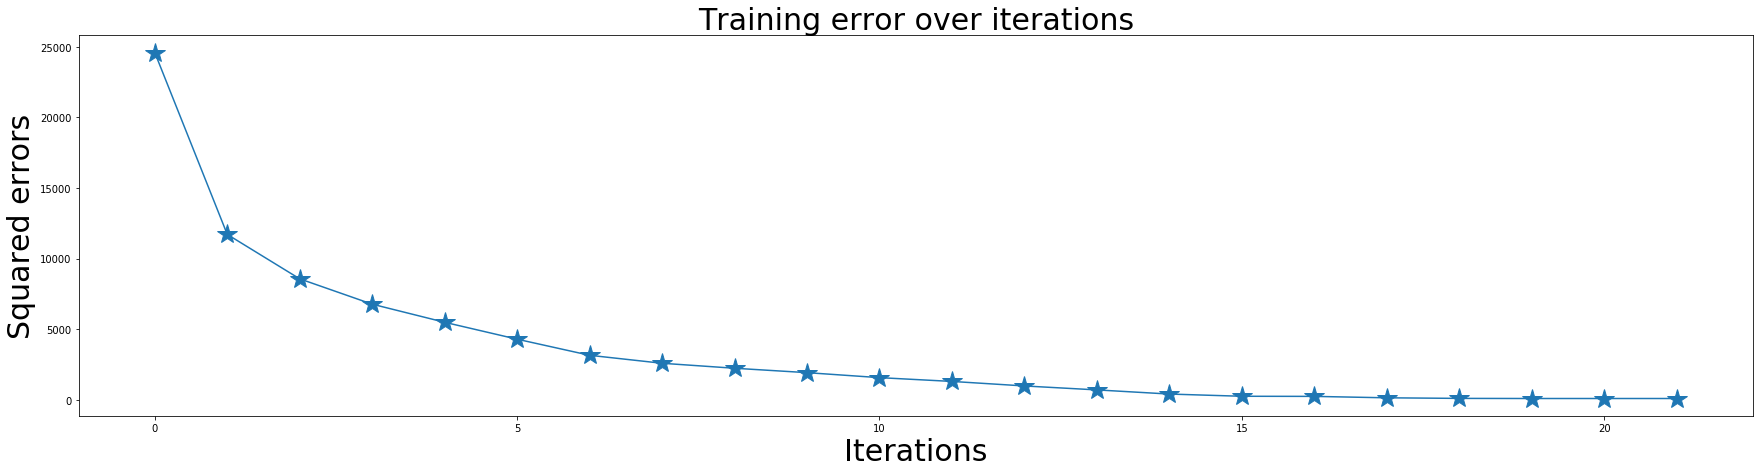

In [11]:
lambda_ = 600
w, error_history = CoordinateLasso(X_train, y_train, lambda_)
_ = plot_error_over_iterations(error_history)

## II. Regularization parameter 
### Coordinate Descent Lasso regression with below conditions

> a. Consider intercept terms   
> b. Consider soft thresholding    
> c. Loss function = RSS   
> d. Initialize weight vectors to random Gaussian with mean of 0 and standard deviation of 1    
> e. Convergence condition: $||\hat w_t - \hat w_{t+1}||_\infty < 10^{-6}$, i.e., $max(abs(\hat w_t - \hat w_{t+1})) < 10^{-6}$, where $t$ is a number of iteration  
> f. Set $\lambda=600$ and adjust it by cutting it down by a factor of 2 until we have models for 10 values of $\lambda$ in total

- Plot the weight coefficient paths for the features $\texttt{agePct12t29}$, $\texttt{pctWSocSec}$, $\texttt{PctKids2Par}$, $\texttt{PctIlleg}$, and $\texttt{HousVacant}$ over $\log(\lambda)$   
- Plot training error (sum of squared error) over $\log(\lambda)$  
- Plot test error (sum of squared error) over $\log(\lambda)$  
- Plot number of nonzero weights over $\lambda$

In [12]:
def stack_weights_by_lambda(lambda_ , X, y):
    
    w_tot = []
    for i, l in enumerate(lambda_):
        w, _ = CoordinateLasso(X, y, l)
        w_tot.append(w)
    
    return np.asarray(w_tot, dtype=np.float32)
    
    
def plot_weights(lambda_, w_tot, dataframe, features):
    
    fig = plt.figure(figsize=(30,7))
    fontsize, legend_fontsize, markersize = 30, 20, 20
    
    for i in range(len(features)):
        index = dataframe.columns.get_loc(features[i])
        plt.plot(np.log(lambda_), w_tot[:,index-1], marker='*', markersize=markersize, label=features[i])
        
    plt.title('Regularization paths', fontsize=fontsize)
    plt.xlabel('log($\lambda$)', fontsize=fontsize)
    plt.ylabel('Weights', fontsize=fontsize)
    plt.xlim(max(np.log(lambda_)), 0)
    plt.legend(loc='upper left', fontsize=legend_fontsize)
    plt.show()

    return fig


def plot_training_error(lambda_, w_tot,  X, y):

    squared_errors = [np.power(y-np.dot(X, w), 2).sum() for w in w_tot]
    
    fig = plt.figure(figsize=(30,7))
    fontsize, markersize = 30, 20
    
    plt.plot(np.log(lambda_), squared_errors , marker='*', markersize=markersize)
    plt.title('Training errors over log($\lambda$)', fontsize=fontsize)
    plt.xlabel('log($\lambda$)', fontsize=fontsize)
    plt.ylabel('Squared errors', fontsize=fontsize)
    plt.show()

    return fig


def plot_test_error(lambda_, w_tot,  X, y):

    squared_errors = [np.power(y-np.dot(X, w), 2).sum() for w in w_tot]
    
    fig = plt.figure(figsize=(30,7))
    fontsize, markersize = 30, 20
    
    plt.plot(np.log(lambda_), squared_errors , marker='*', markersize=markersize)
    plt.title('Test errors over log($\lambda$)', fontsize=fontsize)
    plt.xlabel('log($\lambda$)', fontsize=fontsize)
    plt.ylabel('Squared errors', fontsize=fontsize)
    plt.show()

    return fig



def plot_number_of_nonzero_index(lambda_, w_tot):

    w_tot = np.array([np.count_nonzero(w) for w in w_tot])
    
    fig = plt.figure(figsize=(30,7))
    fontsize, markersize = 30, 20
    
    plt.plot(lambda_, w_tot, marker='*', markersize=markersize)
    plt.title('Number of non-zero weights', fontsize=fontsize)
    plt.xlabel('$\lambda$', fontsize=fontsize)
    plt.ylabel('Number of non-zero weights', fontsize=fontsize)
    plt.show()

    return fig

In [13]:
lambda_ = np.array([600.0 / (2 ** i) for i in range(10)])
w_tot = stack_weights_by_lambda(lambda_ , X_train, y_train)
print(w_tot.shape)

(10, 96)


In [14]:
features = ['agePct12t29', 'pctWSocSec', 'PctKids2Par', 'PctIlleg', 'HousVacant']

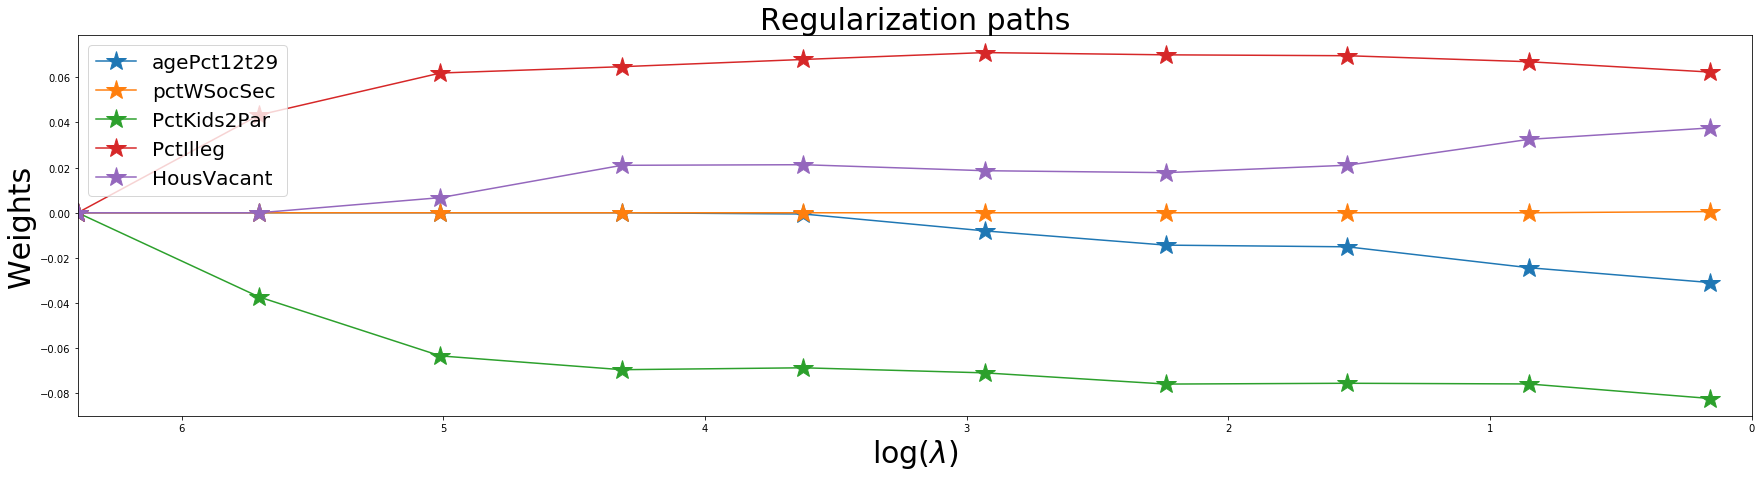

In [15]:
_ = plot_weights(lambda_, w_tot, df_train, features)

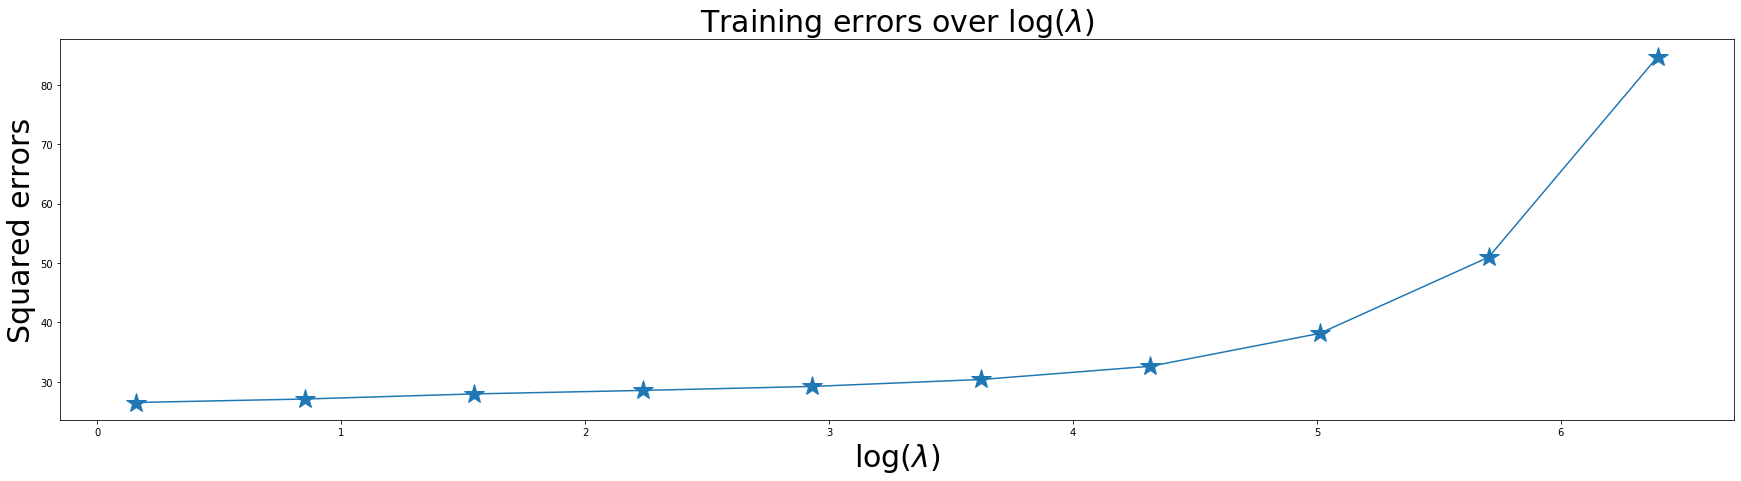

In [16]:
_ = plot_training_error(lambda_, w_tot, X_train, y_train)

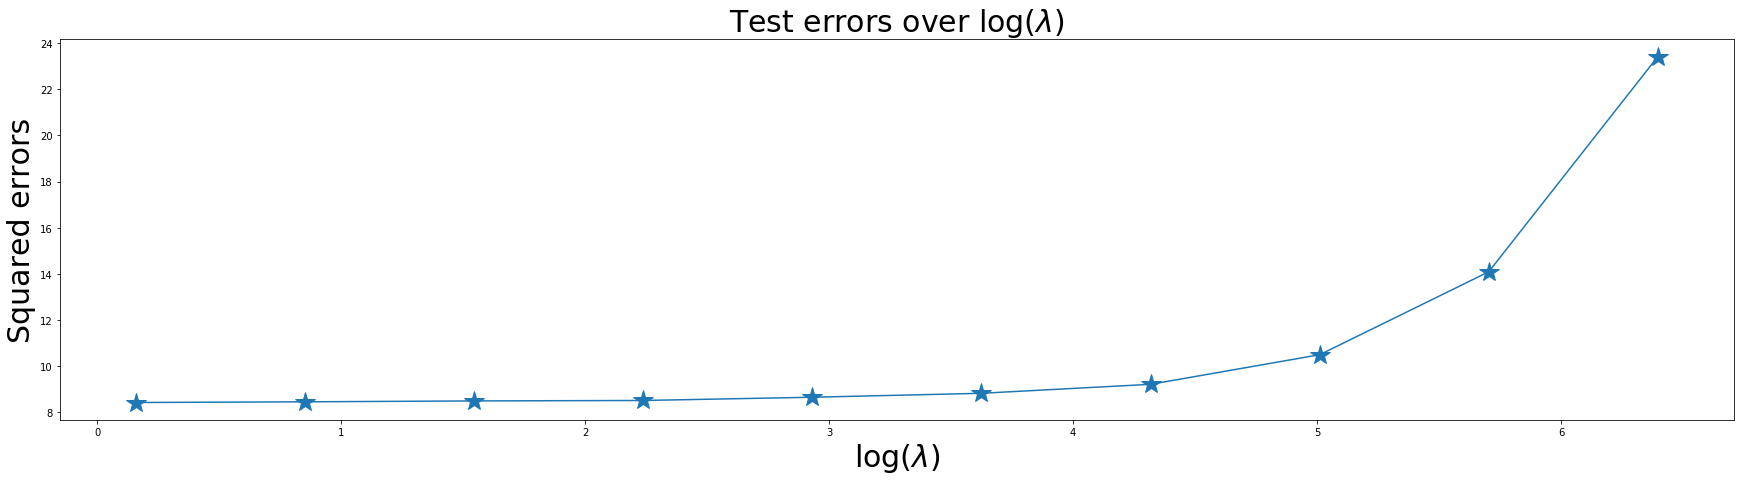

In [17]:
_ = plot_test_error(lambda_, w_tot, X_test, y_test)

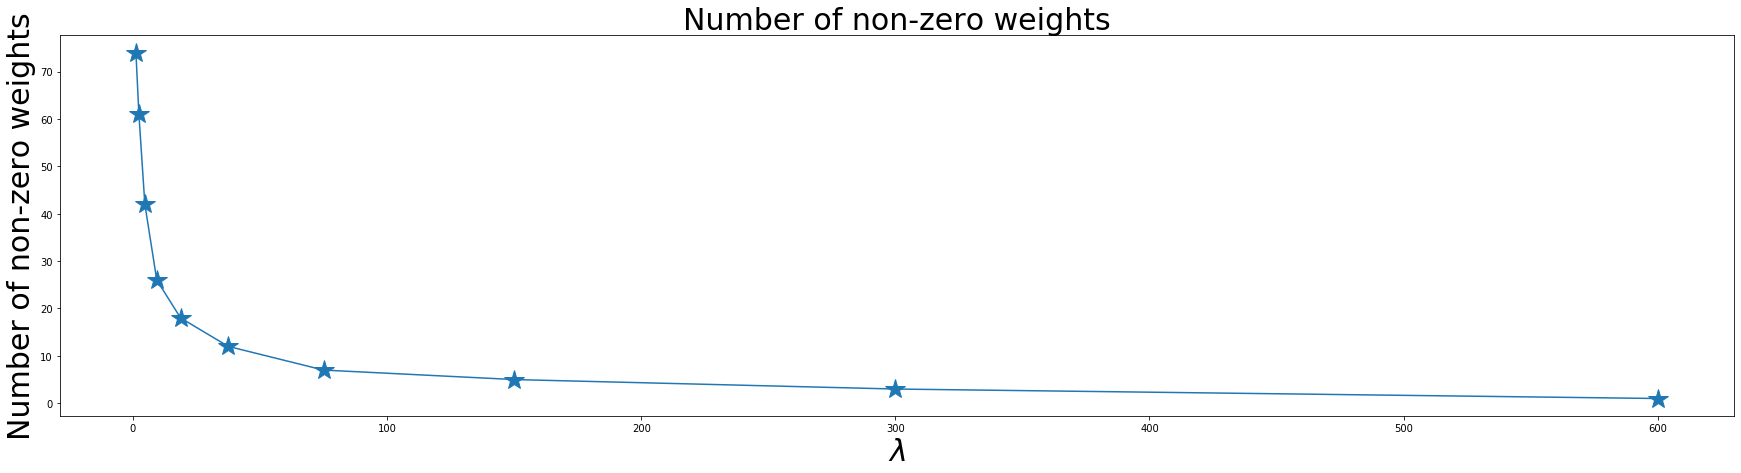

In [18]:
_ = plot_number_of_nonzero_index(lambda_, w_tot)